# Effect of Dither and ACIS Frame Time on Spatial Resolution


Chandra dithers during an observation (usually). 

But, it dithers slowly.

The aspect is computed every 0.256 seconds (usually).

ACIS obtains data by integrating an exposure for ~`TIMEDEL` seconds.  This varies with with the size of any subarray readout combined with the number of active CCDs. 

Any event detected during that time interval is given a `TIME` tag equal to the middle of that interval.

However, Chandra dithers.

A source on the sky will move across the CCD during the `TIMEDEL` seconds.  

The dither is slow compared to the ACIS exposure time (REF); but at subpixel resolutions, the effect can be quantified.

This notebook shows how to quantify this effect.


## Setup

Perform some Python setup to let CIAO stuff work here.

In [1]:
# Add CIAO packages to path

import os
import sys
assert "ASCDS_INSTALL" in os.environ, "CIAO must be running to use this notebook"

_ciaodir = os.environ["ASCDS_INSTALL"]
_libname = "python{}.{}".format(sys.version_info.major,
                                sys.version_info.minor)
_pathdir = os.path.normpath(os.path.join(_ciaodir, 'lib', _libname, 'site-packages'))
os.sys.path.insert(0, _pathdir)

_pathdir = os.path.normpath(os.path.join(_ciaodir, 'contrib', 'lib', _libname, 'site-packages'))
os.sys.path.insert(0, _pathdir)



In [2]:
from pychips import *
from pychips.hlui import *
load_preferences()

from pycrates import read_file
import numpy as np

In [3]:
# Inline chips plots into notebook

def my_print(fmt=".png"):
    "Display the current ChIPS window in IPython as a PNG"
    import IPython.core.display as display
    import tempfile as tempfile
    import os as os
    fname = tempfile.mkstemp(prefix='chips_temp', suffix=fmt, dir=os.environ["ASCDS_WORK_PATH"])[1]
    # Get ChIPS to create a PNG of the current window
    print_window(fname, 'clobber=true')
    assert os.path.exists(fname) == True
    img = display.Image(filename=fname)
    display.display_png(img)
    os.unlink(fname)

## Download Data

We start by downloading and reproecessing the data.  We don't really need to run `chandra_repro` here, but we might as well.


In [4]:
OBS_ID="3141"
CCD_ID="7"

---

Download and rerprocess the data

In [5]:
os.system("/bin/rm -rf "+OBS_ID)

0

In [6]:
from ciao_contrib.cda.data import download_chandra_obsids
download_chandra_obsids([OBS_ID], 
    filetypes=["evt1","bpix","asol","msk","flt","mtl","stat","pbk","bias","full_img"])

[True]

In [7]:
from ciao_contrib.runtool import chandra_repro
print(chandra_repro(OBS_ID, OBS_ID+"/repro"))


Processing input directory '/data/lenin2/Projects/AspectDistance/3141'

Resetting afterglow status bits in evt1.fits file...

Running the destreak tool on the evt1.fits file...

Running acis_build_badpix and acis_find_afterglow to create a new bad pixel file...

Running acis_process_events to reprocess the evt1.fits file...
Output from acis_process_events:
# acis_process_events (CIAO 4.10): The following error occurred 29 times:
	dsAPEPULSEHEIGHTERR -- WARNING: pulse height is less than split threshold when performing serial CTI adjustment.
Filtering the evt1.fits file by grade and status and time...
Applying the good time intervals from the flt1.fits file...
The new evt2.fits file is: /data/lenin2/Projects/AspectDistance/3141/repro/acisf03141_repro_evt2.fits

Updating the event file header with chandra_repro HISTORY record
Creating FOV file...
Setting observation-specific bad pixel file in local ardlib.par.

Cleaning up intermediate files

         /data/lenin2/Projects/AspectDistanc

In [8]:
# Locate the files we'll need
import glob
asol1=glob.glob(OBS_ID+"/primary/pcad*asol1.fits*")
stat1=glob.glob(OBS_ID+"/secondary/acisf*stat1.fits*")
img2=glob.glob(OBS_ID+"/primary/acisf*full_img2.jpg")
assert len(asol1) == 1, "Only single asol file supported"
assert len(stat1) == 1, "Only single stat1 file supported"
asol1 = asol1[0]
stat1 = stat1[0]

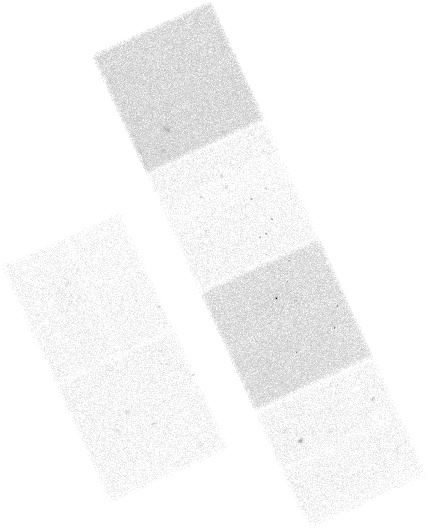

In [9]:
# Let's just display a pict so we know what we're looking at
import IPython.core.display as display
display.display_jpeg(display.Image(img2[0]))

## Event times vs. Aspect Times

ACIS and PCAD are independent instruments that produce results on independent time grids.

ACIS typically produces data every ~3.2 seconds (varies with number of active chips and if subarrays were used).

PCAD typically produces data every ~0.256 seconds, but may be as long as 32 seconds depending on the telemetry format.

`acis_process_events`, `tg_resolve_events`, and `hrc_process_events` use the last aspect solution time record before the time of the event.


`libdev/lev1/l1_asplib/l1_aspect_function.c` :

```C
/*
* FUNCTION NAME: aspect_update()
 
* DESCRIPTION:

    The routine aspect_update is called upon by [foo]_process_events to   
    update the pixel library's aspect values as necessary. The routine is 
    called once for each event and uses the event's time field to determine 
    whether or not the aspecting position needs to be adjusted. If so, it 
    will search through the aspect file (or a stack of aspect files) for a
    time interval that encompasses the current event's timestamp. As it 
    does so the pixel library is called and updated for all aspect 
    positions whose time ranges occur before the event's time. 

```


### Aspect Solution

First, let's load and look at the aspect solution.

The `TIMEDEL` keyword is the time between aspect solution records.

The `TIMEPIXR` keyword is used to indicate whether the `TIME` values are for the beginning (`0`), the middle (`0.5`), or the end (`1`) of the time interval.

In [10]:
asp = read_file(asol1)
asp_times = asp.get_column("time").values
asp_deltaT = asp.get_key_value("timedel")
asp_Tpixr = asp.get_key_value("timepixr")
print([asp_deltaT,asp_Tpixr])

[0.25624999999999998, 0.0]


Okay, so these aspect solution records are ~0.256s apart and the times are for the beginning of the time interval.

In [11]:
# To make the plot cleaner we will subtract off a common time from all the data.

T0 = asp_times[0]

In [12]:
# Setup the plot
clear()
add_window(1024,512)
set_preference("plot.topmargin","0.07")
set_preference("plot.leftmargin","0.07")
set_preference("plot.bottommargin","0.07")
set_preference("plot.rightmargin","0.07")

In [13]:
# Plot the data, we use X-error bars to show the time interval based on 
# TIMEDEL and TIMEPIXR

xx = asp_times-T0
yy = np.ones_like(xx)
yerr = np.zeros_like(xx)
xx_err_lo = np.zeros_like(xx)+asp_Tpixr*asp_deltaT
xx_err_hi = np.zeros_like(xx)+(1-asp_Tpixr)*asp_deltaT

errs = [yerr,yerr,xx_err_lo,xx_err_hi]
add_curve( xx, yy, errs)
set_curve("line.style=none symbol.style=square err.style=capped err.caplength=20")

### Look at the event times

Well, we will look at the time in the _event statistics_ aka `stat1` file.  

The event file only has times when there are actually events.  The `stat1` files contains the
time tags for each ACIS exposure whether there are any events or not.

We need to know the `CCD_ID` because each chip is actually read out at different time.  [Ie, exposure number, `EXPNO`, 10 on `CCD_ID=7` will have a different `TIME` value than `EXPNO=10` on `CCD_ID=6`.]  

> This has to do with power consumption during the frame transfer that is beyond the scope of this discussion.



In [14]:
# Repeat for the STAT1 file.

st = read_file(stat1+"[ccd_id={}]".format(CCD_ID))
st_times = st.get_column("time").values
st_deltaT = st.get_key_value("timedel")
st_Tpixr = st.get_key_value("timepixr")
print([st_deltaT,st_Tpixr])

[3.2410399999999999, 0.5]


In [15]:
# Plot the data, we use X-error bars to show the time interval based on 
# TIMEDEL and TIMEPIXR

xx = st_times-T0
yy = np.ones_like(xx)+1
yerr = np.zeros_like(xx)
xx_err_lo = np.zeros_like(xx)+st_Tpixr*st_deltaT
xx_err_hi = np.zeros_like(xx)+(1-st_Tpixr)*st_deltaT

errs = [yerr,yerr,xx_err_lo,xx_err_hi]
add_curve( xx, yy, errs)
set_curve("line.style=none symbol.style=square err.style=capped err.caplength=20")

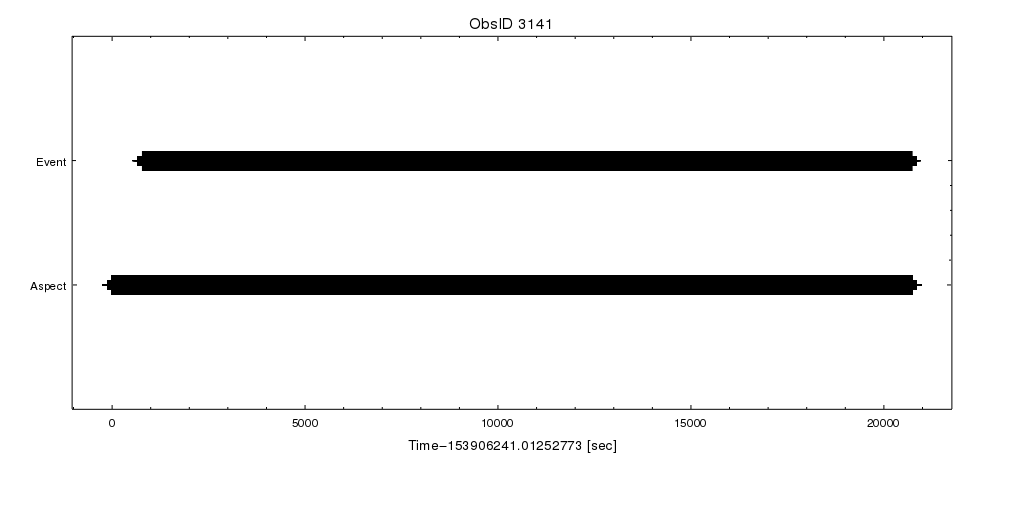

In [16]:
# Add plot labels/title

set_plot_title("ObsID "+OBS_ID)
set_plot_xlabel("Time-{} [sec]".format(T0))
set_axis("ay1", "minortick.visible=False majortick.mode=arbitrary")
set_arbitrary_tick_positions("ay1", [1, 2], ["Aspect", "Event"])
set_plot("bottommargin=0.2")
limits(Y_AXIS, 0, 3)
my_print()

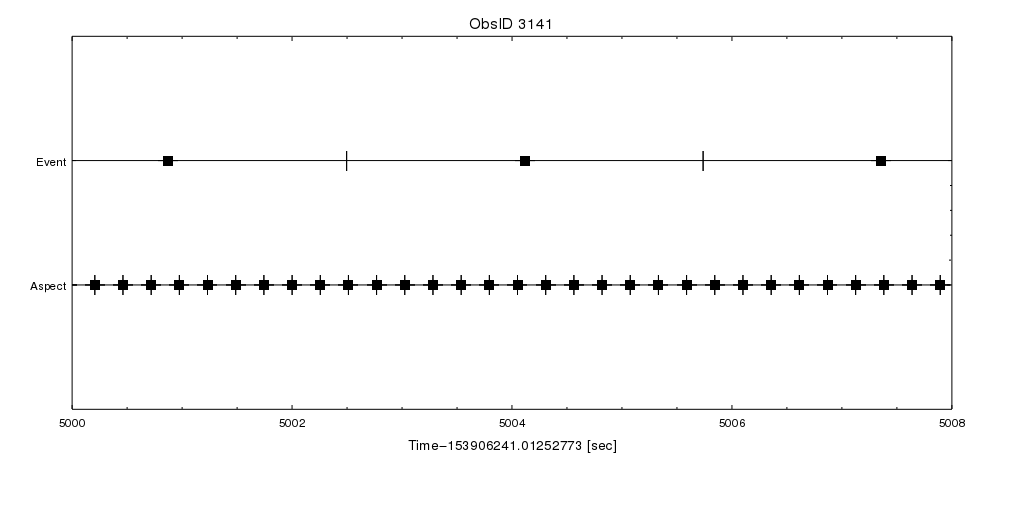

In [17]:
# Zoom into a time range around a single exposure

limits(X_AXIS, 5000,5008)
my_print()


The black squares show the `TIME` value from the aspect solution and event statistics file.  The vertical bars show the start/stop time for the interval containing the event|aspect time.

**All events recorded during the exposure are all given the same `TIME`**.

As we see here, there are multiple aspect solution data points that are recorded during any ACIS exposure.

We do not know when during the ACIS exposure the event was recorded, therefore there is some
uncertainity in the aspect reconstruction.  We would like to know the size of this uncertainity.


## Identify aspect records

We can replicate the `l1_asp::aspect_update` logic here to identify which aspect records where **the** records that were used to reconstruct the event position.  

> The other aspect records are ignored.

The logic is fairly simple.  The *last* aspect records that *occured* before the event time is used.  

> There is a bit of extra logic to deal with the beginning of an observation where there may be event data but no aspect solution.  However, there is no special handling of the end of the observation; the last aspect record is used for all events that occur after it.  But note: those times are removed from the Level2 event file.


In [18]:
# Identify which ASOL time was used for each ACIS exposure

used_asol_times = []
for tt in st_times:
    less_than = asp_times[asp_times<=tt]
    try:
        used_asol_times.append(less_than[-1])
    except:
        used_asol_times.append(np.nan)
xx = np.array(used_asol_times)-T0
yy = np.ones_like(used_asol_times)
add_curve(xx,yy, "symbol.style=square symbol.color=firebrick")

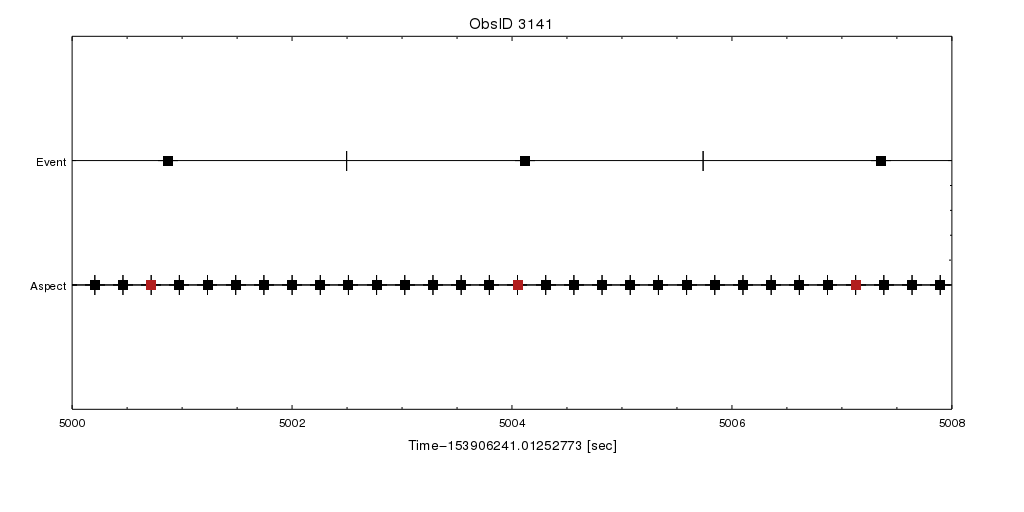

In [19]:
my_print()


So the way it works is that all the events within the Event time interval are all given the same event time (~5004).  The events are detected during a single exposure -- but we don't know when within the exposure they were detected so they all get the time of the middle of the exposure.

All these events will use the same aspect solution record at the time shown (just before ~5004).   Any events detected
near the middle of the exposure frame time will have an accurate aspect solution; which events detected at the beginning and end of the exposure suffering from inaccurate aspect solution.


## How much does ASOL change during an ACIS exposure?


Now that we know which aspect solution records are used, we now want to understand how much does the aspect solution change relative to record during each exposure.

We can take a quick look at just the raw `RA` and `DEC` values during this time interval


In [20]:
ra = asp.get_column("ra").values
dec = asp.get_column("dec").values

nn = np.bitwise_and( asp_times-T0 >=5000, asp_times-T0 <= 5008)

med_ra = np.median(ra[nn])
med_dec = np.median(dec[nn])


In [21]:
clear()
add_window(1024,512)
set_preference("plot.topmargin","0.07")
set_preference("plot.leftmargin","0.07")
set_preference("plot.bottommargin","0.07")
set_preference("plot.rightmargin","0.07")
strip_chart(2)

In [22]:
set_current_plot('plot1')
add_curve( asp_times-T0, (ra-med_ra)*3600)
set_plot_ylabel("RA-{:.6} [arcsec]".format(med_ra))
yl = np.min(ra[nn]-med_ra)*3600
yh = np.max(ra[nn]-med_ra)*3600
limits(Y_AXIS,yl,yh) 
set_axis("ay1", "offset.perpendicular=60")

In [23]:
set_current_plot('plot2')
add_curve( asp_times-T0, (dec-med_dec)*3600)
set_plot_ylabel("DEC-{:.6} [arcsec]".format(med_dec))
set_plot_xlabel("Time-{}".format(T0))
set_axis("ax1", "offset.perpendicular=30")
set_axis("ay1", "offset.perpendicular=60")
yl = np.min(dec[nn]-med_dec)*3600
yh = np.max(dec[nn]-med_dec)*3600
limits(Y_AXIS,yl,yh) 
limits(X_AXIS, 5000,5008)

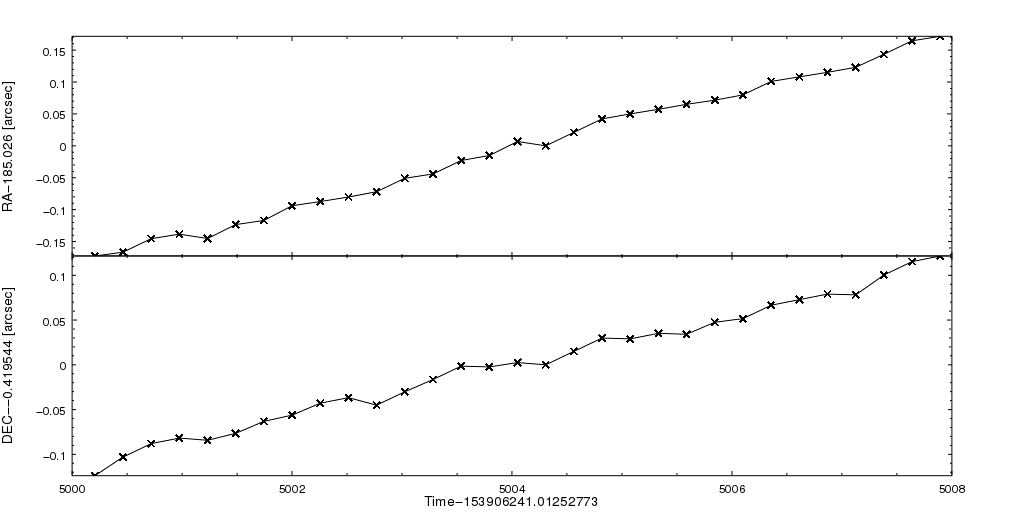

In [24]:
my_print()

## Compute distance

It's hard to see from the above plot the magnitude of the change, especially relative to the ACIS pixel size (0.492 arcsec/pixel).

Instead we can compute the distance from each aspect record relative to the aspect record used to reconstruct the event position.  

Since we want to understand the worst case situation, we compute the **maximum** distance between any aspect point in the event time interval (relative to the record used to reconstruct the event position).  

> The best case scenaro is that events were detect in the 0.256s interval actually used.



In [25]:
# Use cos(dec) approximation for dist calcs
dec_nom = asp.get_key_value("DEC_NOM")
cos_dec = np.cos( np.deg2rad(dec_nom))

dra_plot = []
ddec_plot = []
max_offset = []
for tt,ut in zip(st_times,used_asol_times):
    # Determine range of asol files around the event time
    lo = tt - st_Tpixr*st_deltaT
    hi = tt + (1.0-st_Tpixr)*st_deltaT
    rr = np.bitwise_and( asp_times >= lo, asp_times < hi)

    # Get the ra & dec value actually used
    used_ra = ra[asp_times==ut]
    used_dec = dec[asp_times==ut]

    # Compute offset, store in arcsec
    dra = (ra[rr]-used_ra)*cos_dec
    ddec = (dec[rr]-used_dec)

    try:
        dra_plot.extend( list(dra*3600))
        ddec_plot.extend(list(ddec*3600))        
    except:
        pass
        
    dist = np.hypot(dra, ddec)
    try:
        max_offset.append(np.max(dist)*3600.0)
    except:
        max_offset.append(np.nan)

We can plot the distance offset during each exposure as a scatter plot to see the type of aspect reconstruction error we might expect to see

In [26]:
clear()
add_window(512,512)
set_preference("plot.topmargin","0.07")
set_preference("plot.leftmargin","0.1")
set_preference("plot.bottommargin","0.08")
set_preference("plot.rightmargin","0.01")

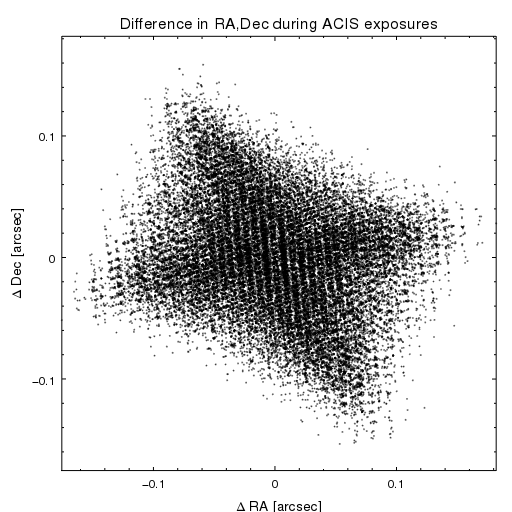

In [27]:
add_curve( dra_plot, ddec_plot, "symbol.style=point line.style=none")        
set_plot_xlabel("\Delta RA [arcsec]")
set_plot_ylabel("\Delta Dec [arcsec]")
set_plot_title("Difference in RA,Dec during ACIS exposures")

# Make plot square, really, really square
set_data_aspect_ratio("1:1")
set_plot_aspect_ratio("1:1")
limits(X_AXIS, min([min(dra_plot),min(ddec_plot)]), max([max(dra_plot),max(ddec_plot)]))
limits(Y_AXIS, min([min(dra_plot),min(ddec_plot)]), max([max(dra_plot),max(ddec_plot)]))

my_print()

And we can plot the cummulative distribution of distances based on the above scatter data 

In [28]:
big_d = np.hypot( dra_plot, ddec_plot)
big_d.sort()
cum_d = np.cumsum(big_d)
cum_d = cum_d/max(cum_d)

sigma = 0.68
one_sigma_idx, = np.where(cum_d<sigma)
one_sigma = big_d[one_sigma_idx[-1]]

print(one_sigma)

0.0894679054863


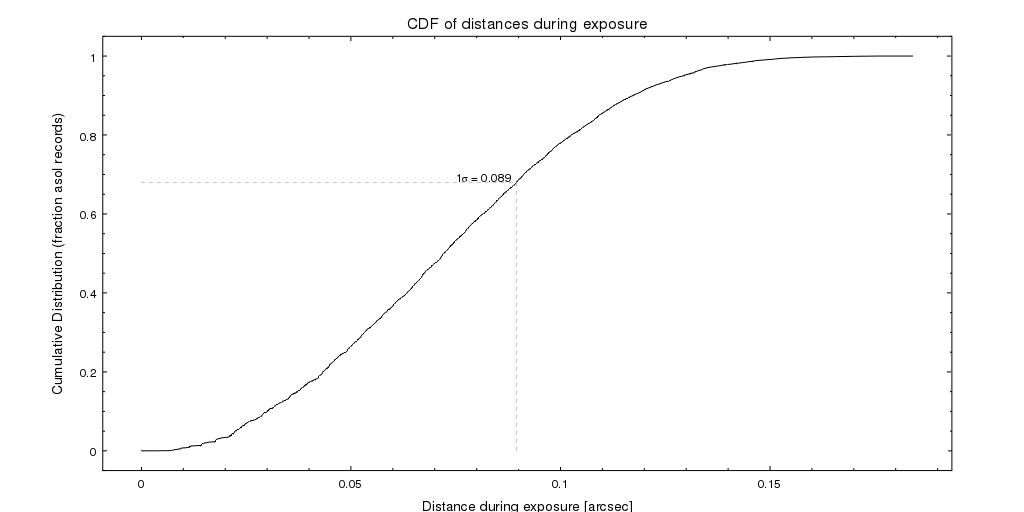

In [29]:
clear()
add_window(1024,512)
set_preference("plot.topmargin","0.07")
set_preference("plot.leftmargin","0.1")
set_preference("plot.bottommargin","0.08")
set_preference("plot.rightmargin","0.07")

add_curve( big_d, cum_d, "symbol.style=none line.style=solid")
add_line( [one_sigma, one_sigma, 0.0],
          [0, sigma, sigma], "line.style=shortdash line.color=gray")
add_label( one_sigma, sigma, "1\sigma = {:.3f}".format(one_sigma), "halign=1.1")
set_plot_xlabel("Distance during exposure [arcsec]")
set_plot_ylabel("Cumulative Distribution (fraction asol records)")
set_plot_title("CDF of distances during exposure")
my_print()

Finally, we can take a look at the worst case senerio -- the max offset during each exposure

In [30]:
# Now create histogram of the MAXIMUM during the exposure

hh = np.histogram( max_offset, bins=50, range=[0,0.5])

In [31]:
# Plot it
clear()
add_window(1024,512)
set_preference("plot.topmargin","0.07")
set_preference("plot.leftmargin","0.07")
set_preference("plot.bottommargin","0.09")
set_preference("plot.rightmargin","0.02")

add_histogram(hh[1][:-1],hh[1][1:],hh[0])

add_vline(0.492, "line.style=shortdash line.color=808080")  # ACIS pixel size

set_plot_xlabel("Offset from Used [arcsec]")
set_plot_ylabel("Counts")
set_plot_title("Frequency of Max offset in ObsId "+OBS_ID)


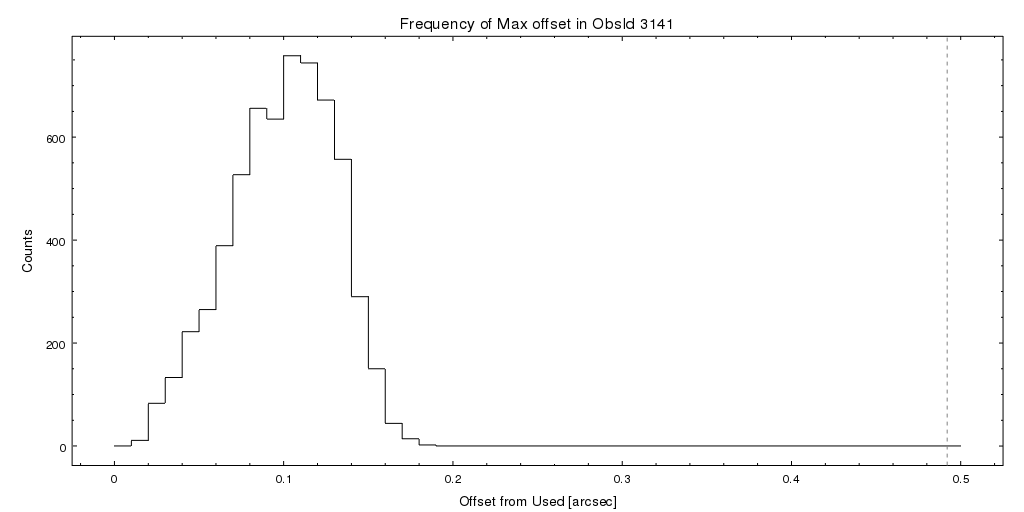

In [32]:
my_print()


So, basically the aspect solution moves by about 0.1" during an exposure, or about 0.25 of the pixel.  

